In [ ]:
!pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d salader/dogs-vs-cats

 99% 1.06G/1.06G [00:13<00:00, 131MB/s]
100% 1.06G/1.06G [00:14<00:00, 77.6MB/s]


In [ ]:
!unzip "/content/dogs-vs-cats.zip" -d "/content/dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/train/dogs/dog.4419.jpg  
  inflating: /content/dataset/train/dogs/dog.442.jpg  
  inflating: /content/dataset/train/dogs/dog.4420.jpg  
  inflating: /content/dataset/train/dogs/dog.4421.jpg  
  inflating: /content/dataset/train/dogs/dog.4422.jpg  
  inflating: /content/dataset/train/dogs/dog.4424.jpg  
  inflating: /content/dataset/train/dogs/dog.4425.jpg  
  inflating: /content/dataset/train/dogs/dog.4426.jpg  
  inflating: /content/dataset/train/dogs/dog.4427.jpg  
  inflating: /content/dataset/train/dogs/dog.4431.jpg  
  inflating: /content/dataset/train/dogs/dog.4433.jpg  
  inflating: /content/dataset/train/dogs/dog.4436.jpg  
  inflating: /content/dataset/train/dogs/dog.4438.jpg  
  inflating: /content/dataset/train/dogs/dog.4439.jpg  
  inflating: /content/dataset/train/dogs/dog.444.jpg  
  inflating: /content/dataset/train/dogs/dog.4440.jpg  
  inflating: /content/dataset/train/dogs/dog.4441.jpg  

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from keras.src.layers import MultiHeadAttention
from tensorflow.keras.layers import Layer, Dropout,MaxPooling2D,GlobalAveragePooling2D,Activation,Add,LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import InputLayer,Dense,Conv2D,MaxPool2D,Flatten,BatchNormalization,Input,RandomFlip, RandomRotation, Resizing, Rescaling,RandomContrast
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TrueNegatives, TruePositives, Precision, Recall, AUC, CategoricalAccuracy,TopKCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy
import sklearn
import tensorflow_probability as tfp
from sklearn.metrics import confusion_matrix, roc_curve
from tensorflow.keras.regularizers import L2, L1
from tensorflow.train import BytesList,FloatList,Int64List
from tensorflow.train import Example, Feature, Features
import seaborn as sns
import  cv2
from tensorflow.keras.callbacks import Callback, CSVLogger,EarlyStopping,LearningRateScheduler,ModelCheckpoint, ReduceLROnPlateau

In [ ]:
train_dataset = "/content/dataset/train"
val_dataset = "/content/dataset/test"

CONFIG = {
    "IM_SIZE" : 256,
    "BATCH_SIZE" : 32,
}

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dataset,
    labels = 'inferred',
    label_mode= 'int',
    image_size= (CONFIG["IM_SIZE"],CONFIG["IM_SIZE"]),
    batch_size= CONFIG["BATCH_SIZE"],
    shuffle= True,
    seed = 123,
)

Found 20000 files belonging to 2 classes.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dataset,
    labels = 'inferred',
    label_mode= 'int',
    image_size= (CONFIG["IM_SIZE"],CONFIG["IM_SIZE"]),
    batch_size= CONFIG["BATCH_SIZE"],
    shuffle= True,
    seed = 123,
)

Found 5000 files belonging to 2 classes.


In [ ]:
CLASS_NAMES = train_ds.class_names
print(CLASS_NAMES)

['cats', 'dogs']


In [ ]:
def resize_rescale(image,label):
  return tf.image.resize(image,(CONFIG["IM_SIZE"],CONFIG["IM_SIZE"])) /.255, label

In [ ]:
train_ds = (
    train_ds
    .map(resize_rescale)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [ ]:
val_ds = (
    val_ds
    .map(resize_rescale)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [ ]:
print(train_ds)
print(val_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
print(f"Train Size: {len(train_ds)}, Val Size: {len(val_ds)}")

Train Size: 625, Val Size: 157


In [ ]:
model = tf.keras.models.Sequential([
    InputLayer(input_shape = (CONFIG["IM_SIZE"],CONFIG["IM_SIZE"],3)),
    Rescaling(1./255,name = "rescaling"),

    Conv2D(filters = 16, kernel_size = 3, strides = 1,padding="valid", activation = 'relu'),
    MaxPooling2D(),
    Conv2D(filters = 32, kernel_size = 3, strides = 1,padding="valid", activation = 'relu'),
    MaxPooling2D(),
    Conv2D(filters = 64, kernel_size = 3, strides = 1,padding="valid", activation = 'relu'),
    MaxPooling2D(),

    Flatten(),

    Dense(256, activation='relu'),
    Dense(1, activation = "sigmoid")
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        1

In [ ]:
model.compile('adam', loss = BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds,epochs=20,validation_data=val_ds, verbose = 1 , batch_size= CONFIG["BATCH_SIZE"])

Epoch 1/20
625/625 [==============================] - 69s 90ms/step - loss: 0.5867 - accuracy: 0.6928 - val_loss: 0.5045 - val_accuracy: 0.7462
Epoch 2/20
625/625 [==============================] - 50s 80ms/step - loss: 0.4550 - accuracy: 0.7820 - val_loss: 0.4783 - val_accuracy: 0.7810
Epoch 3/20
625/625 [==============================] - 47s 75ms/step - loss: 0.3463 - accuracy: 0.8453 - val_loss: 0.5281 - val_accuracy: 0.7720
Epoch 4/20
625/625 [==============================] - 51s 82ms/step - loss: 0.2141 - accuracy: 0.9112 - val_loss: 0.7244 - val_accuracy: 0.7846
Epoch 5/20
625/625 [==============================] - 51s 80ms/step - loss: 0.1048 - accuracy: 0.9607 - val_loss: 0.9667 - val_accuracy: 0.7944
Epoch 6/20
625/625 [==============================] - 51s 81ms/step - loss: 0.0670 - accuracy: 0.9778 - val_loss: 1.1378 - val_accuracy: 0.7846
Epoch 7/20
625/625 [==============================] - 50s 79ms/step - loss: 0.0546 - accuracy: 0.9829 - val_loss: 1.1691 - val_accuracy:

In [ ]:
model.evaluate(val_ds)

157/157 [==============================] - 8s 48ms/step - loss: 1.6494 - accuracy: 0.7748


[1.6493654251098633, 0.7748000025749207]

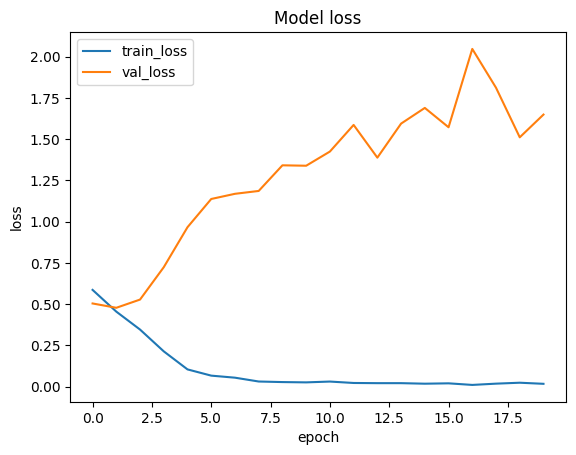

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(["train_loss","val_loss"])
plt.show()

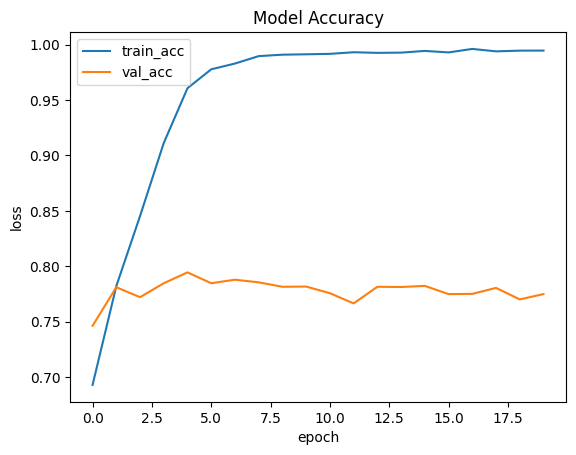

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(["train_acc","val_acc"])
plt.show()

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
model.save("cats_dogs.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
